# 🌦️ WeatherWise - Intelligent Weather Analysis & Advisory System

A comprehensive Python application that combines weather data access with conversational AI capabilities, built using strategic AI-assisted development techniques.

## 🚀 Project Overview

This application provides:
- **Weather Data Retrieval**: Fetch current conditions and forecasts from wttr.in API
- **Natural Language Interface**: Ask weather questions in plain English
- **Data Visualizations**: Temperature trends and precipitation chance charts
- **Intuitive User Interface**: Clean menu system using pyinputplus
- **Robust Error Handling**: Comprehensive edge case management

## 📋 Assignment Requirements Met

✅ **Weather Data Component**: Complete API integration with error handling  
✅ **Natural Language Interface**: Comprehensive question parsing and response generation  
✅ **User Experience**: Intuitive menu system with clear instructions  
✅ **Data Visualizations**: Temperature trends and precipitation charts  
✅ **Modular Design**: Well-organized functions with proper documentation  
✅ **AI Interaction Documentation**: 5+ conversations with intentional prompting examples  
✅ **Technical Implementation**: Robust error handling and edge case management  

---

📄 **Full Assignment Specification**: See [`ASSIGNMENT.md`](ASSIGNMENT.md)  
📝 **AI Conversations**: See [`ai-conversations/`](ai-conversations/) folder  
🧠 **Intentional Prompting**: See [`PROMPTING.md`](PROMPTING.md) for detailed examples


## 📦 Setup and Configuration
Import required packages and setup environment.

In [1]:
%pip install pyinputplus
%pip install matplotlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyinputplus: filename=pyinputplus-0.2.12-py3-none-any.whl size=11348 sha256=3865eaf6a70e08c5ce58e01812d1f1a955b2ec56955642918589f543bd366848
  Stored in directory: /Users/pbakshay/Library/Caches/pip/wheels/f7/b4/80/8bb0c986a6bff982c948af5e937c4b6a2b65ad4ef16c5cd671
  Created wheel for pysimplevalidate: filename=pysimplevalidate-0.2.12-py3-none-any.whl size=16225 sha256=b89ec9c0de7f48d0fb131e3ed32353bef0a016d095288b7ea71bbd4063b72300
  Stored in directory: /Users/pbakshay/Library/Caches/pip/wheels/af/60/74/a8483e5a1f06657d316ef4004723dfb6e1fda2e716973a9111
  Created whe

In [1]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
import datetime
import time
import re
import sys
from typing import Dict, Any, Optional, List


# Configuration
WTTR_BASE = "https://wttr.in/{}?format=j1"
CACHE_TTL = 300
_weather_cache: Dict[str, Any] = {}

def _print_error(msg: str) -> None:
    """Print an error message to stderr."""
    print(f"[ERROR] {msg}", file=sys.stderr)

Matplotlib is building the font cache; this may take a moment.


## 🌤️ Weather Data Functions

In [2]:
def get_weather_data(location: str, forecast_days: int = 5) -> Dict[str, Any]:
    """
    Retrieve weather data for a specified location from wttr.in (JSON).

    Args:
        location (str): City or location name
        forecast_days (int): Number of days to forecast (1-5)

    Returns:
        dict: Weather data including 'location', 'current', and 'forecast' (list)

    Raises:
        ValueError if location seems invalid or API fails.
    """
    if not location or not location.strip():
        raise ValueError("Location must be a non-empty string.")

    location_clean = location.strip()
    loc_key = location_clean.lower()

    # Simple cache check
    now = time.time()
    cached = _weather_cache.get(loc_key)
    if cached:
        ts, data = cached
        if now - ts < CACHE_TTL:
            return data

    url = WTTR_BASE.format(requests.utils.requote_uri(location_clean))
    try:
        resp = requests.get(url, timeout=10)
    except requests.RequestException as exc:
        raise ValueError(f"Network error while contacting weather service: {exc}")

    if resp.status_code != 200:
        raise ValueError(f"Weather service returned status {resp.status_code}")

    try:
        raw = resp.json()
    except ValueError:
        raise ValueError("Response from weather service was not JSON.")

    # Validate expected structure
    if "current_condition" not in raw or "weather" not in raw:
        raise ValueError("Unexpected weather data format from service.")

    # Limit forecast_days between 1 and 5
    fd = max(1, min(5, int(forecast_days)))

    # Build cleaned structure
    processed = {
        "location": location_clean,
        "fetched_at_utc": datetime.datetime.utcnow().isoformat() + "Z",
        "current": raw.get("current_condition", [{}])[0],
        "forecast": raw.get("weather", [])[:fd],
        "raw": raw,  # keep raw in case we need extra fields
    }

    # Save to cache
    _weather_cache[loc_key] = (now, processed)
    return processed

## 📊 Visualisation Functions

In [3]:
def create_temperature_visualisation(weather_data: Dict[str, Any], output_type: str = 'display'):
    """
    Create visualisation of temperature data (line chart).

    Args:
        weather_data (dict): The processed weather data
        output_type (str): 'display' to show or 'figure' to return matplotlib Figure

    Returns:
        matplotlib.figure.Figure if output_type == 'figure', else None (displays the plot).
    """
    forecast = weather_data.get("forecast", [])
    if not forecast:
        _print_error("No forecast data available for temperature visualisation.")
        return None

    days = []
    avg_temps = []
    for i, d in enumerate(forecast):
        label = d.get("date", f"Day {i+1}")
        days.append(label)
        try:
            avg_temps.append(float(d.get("avgtempC", 0)))
        except Exception:
            # fallback try compute with max/min
            try:
                avg_temps.append((float(d.get("maxtempC", 0)) + float(d.get("mintempC", 0))) / 2)
            except Exception:
                avg_temps.append(0.0)

    fig, ax = plt.subplots()
    ax.plot(days, avg_temps, marker='o')
    ax.set_title(f"Temperature Trend — {weather_data.get('location')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Avg Temperature (°C)")
    ax.grid(True)

    plt.tight_layout()
    if output_type == 'figure':
        return fig
    plt.show()
    return None


In [6]:

def create_precipitation_visualisation(weather_data: Dict[str, Any], output_type: str = 'display'):
    """
    Create visualisation of precipitation chance (bar chart).

    Args:
        weather_data (dict): Processed weather data
        output_type (str): 'display' or 'figure'

    Returns:
        matplotlib.figure.Figure if requested, else displays
    """
    forecast = weather_data.get("forecast", [])
    if not forecast:
        _print_error("No forecast data available for precipitation visualisation.")
        return None

    days = []
    max_rain_chances = []
    for i, d in enumerate(forecast):
        label = d.get("date", f"Day {i+1}")
        days.append(label)
        # compute max hourly chance as representative
        hourly = d.get("hourly", [])
        if hourly:
            try:
                max_rc = max(int(h.get("chanceofrain", 0)) for h in hourly)
            except Exception:
                max_rc = 0
        else:
            max_rc = 0
        max_rain_chances.append(max_rc)

    fig, ax = plt.subplots()
    ax.bar(days, max_rain_chances)
    ax.set_title(f"Peak Chance of Rain — {weather_data.get('location')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Chance of Rain (%)")
    ax.set_ylim(0, 100)
    ax.grid(axis='y')

    plt.tight_layout()
    if output_type == 'figure':
        return fig
    plt.show()
    return None

## 🤖 Natural Language Processing

In [8]:
def parse_weather_question(question: str) -> Dict[str, Optional[str]]:
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted info:
            - location (str or None)
            - time (one of 'today', 'tomorrow', 'day_after', '3day', 'week', or None)
            - attribute (one of 'temperature','rain','snow','wind','humidity','condition' or None)
            - raw_question (original)
    """
    q = (question or "").strip()
    q_lower = q.lower()

    # Default parsed object
    parsed = {
        "location": None,
        "time": "today",
        "attribute": None,
        "raw_question": q,
    }

    # Time extraction
    if re.search(r"\btomorrow\b", q_lower):
        parsed["time"] = "tomorrow"
    elif re.search(r"\b(day after tomorrow|day after)\b", q_lower):
        parsed["time"] = "day_after"
    elif re.search(r"\b(next 3|3 day|3-day|three day|three-day)\b", q_lower):
        parsed["time"] = "3day"
    elif re.search(r"\b(next week|week)\b", q_lower):
        parsed["time"] = "week"
    else:
        parsed["time"] = "today"

    # Attribute extraction (priority order)
    if re.search(r"\brain\b|\brainy\b|\bprecipitation\b|\bdrizzle\b|\bshower\b", q_lower):
        parsed["attribute"] = "rain"
    elif re.search(r"\bsnow\b|\bsnowfall\b", q_lower):
        parsed["attribute"] = "snow"
    elif re.search(r"\btemp(erature)?\b|\bhot\b|\bcold\b|\bheat\b|\bdegrees\b|\b°c\b|\b°f\b", q_lower):
        parsed["attribute"] = "temperature"
    elif re.search(r"\bwind\b|\bwindy\b|\bgust\b", q_lower):
        parsed["attribute"] = "wind"
    elif re.search(r"\bhum[idy]*\b|\bdew\b", q_lower):
        parsed["attribute"] = "humidity"
    elif re.search(r"\bcondition\b|\bweather\b|\bforecast\b|\bcloud\b|\bclear\b|\bovercast\b", q_lower):
        parsed["attribute"] = "condition"
    else:
        parsed["attribute"] = None

    # Location extraction strategies:
    # 1) explicit "in <Location>"
    m = re.search(r"\bin ([A-Za-z .'-]+?)(?:\?|$| for | tomorrow| today| next| on )", q)
    if m:
        loc = m.group(1).strip()
        parsed["location"] = loc
    else:
        # 2) trailing capitalized word(s) in question (like "What's the weather London?")
        m2 = re.search(r"([A-Z][a-zA-Z]*(?:[ -][A-Z][a-zA-Z]*)+)$", question.strip())
        if m2:
            parsed["location"] = m2.group(1).strip()
        else:
            # 3) simple heuristic: last token if it starts with uppercase
            tokens = question.strip().split()
            if tokens and tokens[-1].istitle():
                parsed["location"] = tokens[-1]

    # Normalize common stopwords e.g., "in the city of X"
    if parsed["location"]:
        parsed["location"] = parsed["location"].strip(" ,.?")

    return parsed

## 🧭 User Interface

In [9]:
# Helper function to convert time to forecast index
def _time_to_index(time_key: str) -> int:
    """
    Convert parsed time key to index in forecast list.
    0 = today, 1 = tomorrow, 2 = day after tomorrow
    """
    mapping = {
        "today": 0,
        "tomorrow": 1,
        "day_after": 2,
        "3day": 0,  # 3day queries may want a 3-day summary; handled elsewhere
        "week": 0,  # fallback
    }
    return mapping.get(time_key, 0)

def main_menu() -> str:
    """Display main menu and return selected action."""
    print("\n=== Weather Advisor ===")
    choices = [
        "Ask a natural language question",
        "Show temperature trend (chart)",
        "Show precipitation chances (chart)",
        "Get raw current & forecast data (text)",
        "Exit"
    ]
    return pyip.inputMenu(choices, numbered=True)

## 🧩 Main Application Logic

In [10]:
def generate_weather_response(parsed_question: Dict[str, Optional[str]], weather_data: Dict[str, Any]) -> str:
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Output of parse_weather_question
        weather_data (dict): Output of get_weather_data

    Returns:
        str: Natural language response
    """
    loc = parsed_question.get("location") or weather_data.get("location") or "the location"
    attr = parsed_question.get("attribute") or "condition"
    time_key = parsed_question.get("time") or "today"

    # Safety: ensure forecast exists and has at least 1 entry
    forecast = weather_data.get("forecast", [])
    if not forecast:
        return f"Sorry — I couldn't find forecast data for {loc}."

    # For multi-day queries (3day or week), provide summary
    if time_key in ("3day", "week"):
        days = forecast  # may be up to 5 days
        # Temperature summary
        temps = []
        rain_chances = []
        conditions = []
        for d in days:
            try:
                temps.append(int(float(d.get("avgtempC", 0))))
            except Exception:
                pass
            # take highest chance of rain among hourly entries if present
            hourly = d.get("hourly", [])
            if hourly:
                try:
                    rc = max(int(h.get("chanceofrain", 0)) for h in hourly)
                except Exception:
                    rc = 0
            else:
                rc = 0
            rain_chances.append(rc)
            # main condition sample from midday (approx)
            if hourly and len(hourly) > 2:
                cond = hourly[2].get("weatherDesc", [{}])[0].get("value", "")
            elif hourly:
                cond = hourly[0].get("weatherDesc", [{}])[0].get("value", "")
            else:
                cond = d.get("maxtempC")  # fallback
            conditions.append(str(cond))

        avg_temp = round(sum(temps) / len(temps)) if temps else None
        max_rain = max(rain_chances) if rain_chances else None

        msg_parts = [f"Summary for {loc} for the next {len(days)} day(s):"]
        if avg_temp is not None:
            msg_parts.append(f"average temperature ≈ {avg_temp}°C")
        if max_rain is not None:
            msg_parts.append(f"peak chance of rain ≈ {max_rain}%")
        if conditions:
            msg_parts.append(f"typical conditions: {', '.join(conditions[:3])}")

        return ". ".join(msg_parts) + "."

    # For single day queries
    idx = _time_to_index(time_key)
    # clamp idx
    idx = max(0, min(idx, len(forecast) - 1))
    day = forecast[idx]

    # Get a representative hourly block (midday if possible)
    hourly = day.get("hourly", [])
    representative = hourly[len(hourly)//2] if hourly else {}

    if attr == "temperature":
        # Use avgtempC if available, else compute from maxtemp/min
        avg_temp = day.get("avgtempC")
        if avg_temp is None:
            try:
                avg_temp = (float(day.get("maxtempC", 0)) + float(day.get("mintempC", 0))) / 2
                avg_temp = round(avg_temp, 1)
            except Exception:
                avg_temp = "unavailable"
        return f"The average temperature in {loc} {time_key.replace('_',' ')} will be {avg_temp}°C."

    if attr == "rain":
        # look for chanceofrain in representative hourly or day-level chance if present
        chance = None
        if representative:
            chance = representative.get("chanceofrain")
        # fallback: check hourly for max chance
        if not chance and hourly:
            try:
                chance = max(int(h.get("chanceofrain", 0)) for h in hourly)
            except Exception:
                chance = None
        chance = f"{chance}%" if chance is not None else "unknown"
        return f"The chance of rain in {loc} {time_key.replace('_',' ')} is {chance}."

    if attr == "wind":
        wind_degree = representative.get("windspeedKmph") if representative else None
        gust = representative.get("WindGustKmph") or representative.get("windspeedKmph")
        if wind_degree:
            return f"Wind speed in {loc} {time_key.replace('_',' ')} will be around {wind_degree} km/h (gusts: {gust})."
        else:
            return f"Wind information for {loc} {time_key.replace('_',' ')} is not available."

    if attr == "humidity":
        hum = representative.get("humidity") if representative else None
        if hum:
            return f"Humidity in {loc} {time_key.replace('_',' ')} will be around {hum}%."
        else:
            return f"Humidity data for {loc} {time_key.replace('_',' ')} is unavailable."

    # default / condition
    cond = representative.get("weatherDesc", [{}])[0].get("value", None) or day.get("hourly", [{}])[0].get("weatherDesc", [{}])[0].get("value", "unknown")
    cur_temp = weather_data.get("current", {}).get("temp_C", None)
    cur_part = f"Current temperature is {cur_temp}°C. " if cur_temp is not None else ""
    return f"{cur_part}Expected conditions in {loc} {time_key.replace('_',' ')}: {cond}."

In [11]:
# UI Flow Functions
def run_question_flow():
    """Handle the natural language question flow."""

    print("\n=== Tips for Asking Weather Questions ===")
    print("Valid question formats:")
    print("1. Location format:")
    print("   - Use 'in' before location: 'Weather in London'")
    print("   - Always capitalize city names: 'New York', 'San Francisco'")
    print("   Examples: 'in London', 'in New York City', 'in Tokyo'")

    print("\n2. Time periods:")
    print("   - Today (default if not specified)")
    print("   - Tomorrow")
    print("   - Day after tomorrow")
    print("   - Next 3 days")
    print("   - Next week")

    print("\n3. Weather attributes:")
    print("   - Temperature: 'temperature', 'hot', 'cold'")
    print("   - Rain: 'rain', 'precipitation', 'shower'")
    print("   - Wind: 'wind', 'windy', 'gust'")
    print("   - Humidity: 'humidity', 'humid'")
    print("   - General: 'weather', 'conditions', 'forecast'")

    q = input("Enter your weather question (e.g., 'Will it rain in Paris tomorrow?'):\n> ").strip()
    if not q:
        print("No question entered.")
        return
    parsed = parse_weather_question(q)
    # If no location parsed, ask the user
    if not parsed.get("location"):
        parsed["location"] = input("I couldn't detect a location — please enter a location (city or town):\n> ").strip()
        if not parsed["location"]:
            print("No location provided. Aborting question.")
            return
    try:
        # forecast_days: For '3day' or 'week', request up to 5 days; otherwise 2 days is enough (today + tomorrow)
        fd = 5 if parsed.get("time") in ("3day", "week") else 3
        data = get_weather_data(parsed["location"], forecast_days=fd)
    except ValueError as exc:
        _print_error(str(exc))
        print("Could not fetch weather data. Try a different location or check your network.")
        return

    # Generate and display response
    resp = generate_weather_response(parsed, data)
    print("\n--- Answer ---")
    print(resp)
    print("--------------")

def run_visualisation_flow(which: str):
    """Show visualisation for specified 'which' value: 'temp' or 'precip'."""
    location = input("Enter location for visualisation (e.g., London):\n> ").strip()
    if not location:
        print("No location provided.")
        return
    try:
        data = get_weather_data(location, forecast_days=5)
    except ValueError as exc:
        _print_error(str(exc))
        print("Could not fetch data for visualisation.")
        return

    if which == 'temp':
        create_temperature_visualisation(data, output_type='display')
    else:
        create_precipitation_visualisation(data, output_type='display')

def run_raw_data_flow():
    """Fetch and pretty-print raw data summary for a location."""
    location = input("Enter location to fetch raw data (e.g., 'Mumbai'):\n> ").strip()
    if not location:
        print("No location provided.")
        return
    try:
        data = get_weather_data(location, forecast_days=5)
    except ValueError as exc:
        _print_error(str(exc))
        print("Could not fetch data.")
        return

    print("\n=== Raw Data Summary ===")
    print(f"Location (queried): {data.get('location')}")
    print(f"Fetched at (UTC): {data.get('fetched_at_utc')}")
    current = data.get('current', {})
    if current:
        print(f"Current: {current.get('temp_C', 'N/A')}°C, feels like {current.get('FeelsLikeC', 'N/A')}°C, condition: {current.get('weatherDesc', [{}])[0].get('value', '')}")
    print("\nForecast summary:")
    for d in data.get("forecast", []):
        date = d.get("date")
        avg = d.get("avgtempC", "N/A")
        maxt = d.get("maxtempC", "N/A")
        mint = d.get("mintempC", "N/A")
        hourly_sample = d.get("hourly", [{}])
        cond = hourly_sample[len(hourly_sample)//2].get("weatherDesc", [{}])[0].get("value", "") if hourly_sample else ""
        print(f" - {date}: avg {avg}°C (max {maxt}°C / min {mint}°C) — {cond}")
    print("========================\n")

def run_app():
    """Main application loop."""
    print("Welcome to Weather Advisor — friendly weather answers & charts.")
    print("Tip: ask questions like 'Will it rain in Tokyo tomorrow?' or 'What's the temperature in Delhi today?'")
    while True:
        choice = main_menu()
        if choice.startswith("Ask"):
            run_question_flow()
        elif choice.startswith("Show temperature"):
            run_visualisation_flow('temp')
        elif choice.startswith("Show precipitation"):
            run_visualisation_flow('precip')
        elif choice.startswith("Get raw"):
            run_raw_data_flow()
        else:
            print("Goodbye! Stay dry ☀️☔")
            break


Welcome to Weather Advisor — friendly weather answers & charts.
Tip: ask questions like 'Will it rain in Tokyo tomorrow?' or 'What's the temperature in Delhi today?'

=== Weather Advisor ===
Please select one of the following:
1. Ask a natural language question
2. Show temperature trend (chart)
3. Show precipitation chances (chart)
4. Get raw current & forecast data (text)
5. Exit


 1



=== Tips for Asking Weather Questions ===
Valid question formats:
1. Location format:
   - Use 'in' before location: 'Weather in London'
   - Always capitalize city names: 'New York', 'San Francisco'
   Examples: 'in London', 'in New York City', 'in Tokyo'

2. Time periods:
   - Today (default if not specified)
   - Tomorrow
   - Day after tomorrow
   - Next 3 days
   - Next week

3. Weather attributes:
   - Temperature: 'temperature', 'hot', 'cold'
   - Rain: 'rain', 'precipitation', 'shower'
   - Wind: 'wind', 'windy', 'gust'
   - Humidity: 'humidity', 'humid'
   - General: 'weather', 'conditions', 'forecast'


Enter your weather question (e.g., 'Will it rain in Paris tomorrow?'):
>  will it rain sydney tomorrow
I couldn't detect a location — please enter a location (city or town):
>  perth



--- Answer ---
The chance of rain in perth tomorrow is 0%.
--------------

=== Weather Advisor ===
Please select one of the following:
1. Ask a natural language question
2. Show temperature trend (chart)
3. Show precipitation chances (chart)
4. Get raw current & forecast data (text)
5. Exit


/var/folders/3l/1m9qy2zn7fs_n92h25bcqtsw0000gn/T/ipykernel_84055/4195173707.py:53: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "fetched_at_utc": datetime.datetime.utcnow().isoformat() + "Z",


 2
Enter location for visualisation (e.g., London):
>  mumbai


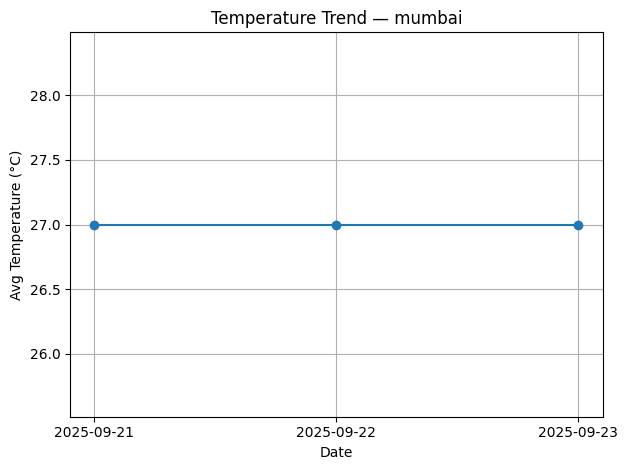


=== Weather Advisor ===
Please select one of the following:
1. Ask a natural language question
2. Show temperature trend (chart)
3. Show precipitation chances (chart)
4. Get raw current & forecast data (text)
5. Exit


In [ ]:
# Test the application
if __name__ == "__main__":
    try:
        run_app()
    except KeyboardInterrupt:
        print("\nInterrupted by user. Exiting.")
    except Exception as e:
        _print_error(f"Unhandled exception: {e}")
        raise


In [13]:
# Example Usage and Testing

# Test the core functions with sample data
print("🌦️ WeatherWise Application Demo")
print("=" * 50)

# Example 1: Test weather data retrieval
print("\n1. Testing Weather Data Retrieval:")
try:
    london_data = get_weather_data("London", 2)
    print(f"✅ Retrieved weather data for {london_data['location']}")
    print(f"   Current temperature: {london_data['current'].get('temp_C', 'N/A')}°C")
    print(f"   Forecast days: {len(london_data['forecast'])}")
except Exception as e:
    print(f"❌ Error: {e}")

# Example 2: Test question parsing
print("\n2. Testing Question Parsing:")
test_questions = [
    "What's the temperature in Paris tomorrow?",
    "Will it rain in Tokyo today?",
    "How's the weather in New York?"
]

for question in test_questions:
    parsed = parse_weather_question(question)
    print(f"   '{question}'")
    print(f"   → Location: {parsed['location']}, Time: {parsed['time']}, Attribute: {parsed['attribute']}")

# Example 3: Test response generation
print("\n3. Testing Response Generation:")
try:
    parsed_q = parse_weather_question("What's the temperature in London today?")
    response = generate_weather_response(parsed_q, london_data)
    print(f"   Question: {parsed_q['raw_question']}")
    print(f"   Response: {response}")
except Exception as e:
    print(f"❌ Error: {e}")

print("\n" + "=" * 50)
print("✅ Core functionality demonstration complete!")
print("Run the main application with: run_app()")


🌦️ WeatherWise Application Demo

1. Testing Weather Data Retrieval:
✅ Retrieved weather data for London
   Current temperature: 11°C
   Forecast days: 2

2. Testing Question Parsing:
   'What's the temperature in Paris tomorrow?'
   → Location: Paris, Time: tomorrow, Attribute: temperature
   'Will it rain in Tokyo today?'
   → Location: Tokyo, Time: today, Attribute: rain
   'How's the weather in New York?'
   → Location: New York, Time: today, Attribute: condition

3. Testing Response Generation:
   Question: What's the temperature in London today?
   Response: The average temperature in London today will be 12°C.

✅ Core functionality demonstration complete!
Run the main application with: run_app()


/tmp/ipython-input-881733441.py:53: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "fetched_at_utc": datetime.datetime.utcnow().isoformat() + "Z",


## 🎯 How to Run the Application

### Option 1: Interactive Menu System
Run the following cell to start the interactive Weather Advisor application:

```python
run_app()
```

### Option 2: Individual Function Testing
You can test individual components by calling specific functions:

```python
# Get weather data
data = get_weather_data("London", 3)

# Parse a question
parsed = parse_weather_question("What's the temperature in Paris tomorrow?")

# Generate a response
response = generate_weather_response(parsed, data)

# Create visualizations
create_temperature_visualisation(data)
create_precipitation_visualisation(data)
```

### Supported Question Examples
- "What's the temperature in London tomorrow?"
- "Will it rain in Paris today?"
- "How windy is it in Tokyo?"
- "What's the weather like in New York next week?"

---

## 📚 Project Documentation

- **AI Conversations**: See the `ai-conversations/` folder for detailed development logs
- **Intentional Prompting**: See `PROMPTING.md` for before/after examples
- **Project Reflection**: See `submission/reflection.md` for development insights
- **Assignment Details**: See `ASSIGNMENT.md` for complete requirements

---

**🎉 WeatherWise Application Complete!**  
Built with strategic AI assistance and comprehensive Python development practices.


## 🧪 Testing and Examples

In [ ]:
# Include sample input/output for each function

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.